#### **IMPORT MODULES**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [7]:
def skew_correction(img):
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 100, 255,cv2.THRESH_BINARY, cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45: angle = -(90 + angle)
    else: angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    plt.imshow(rotated)
    name = './image.jpg'
    cv2.imwrite(name, rotated)
    return name

#### **LINE SEGMENTATION**

In [20]:
def line_one(img, col):
    change = False
    if col != None:
        for co in range(col, img.shape[0]):
            if not all(img[co, :] == 0):
                change = True
                return co
            elif not all(img[co, :] == 0) and change == False: return None

def line_two(img, col, step):
    if col != None:
        for co in range(col, img.shape[0], step):
            if all(img[co, :] == 0):
                return co
    else:
        print('============================Curation complete======================================')
        print('\n =========================== Correcting line segmentation============================ ')

def line_curate(path, step = 5):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    img = cv2.threshold(gray, 130, 255,cv2.THRESH_BINARY)[1]
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    names = []  
    start = 0
    end = 0
    count = 0
    leng = []
    while start != None:
        start = line_one(img,end)
        end = line_two(img, start, step)
        if start != None and end!= None:
            new = img[start:end,:]
            new = cv2.copyMakeBorder(new,2,2,2,2,cv2.BORDER_CONSTANT,value=0) 
            plt.figure(figsize=(10, 10))
            plt.imshow(new, cmap = 'gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.show()
            count += 1
            name = 'horizontal{}.jpg'.format(count)
            names.append(name)
            cv2.imwrite(name, new)
            leng.append(end-start)
    return names,leng

#LINE SEGMENTAION CORRECTION CODE
def line_correct(names, leng):
    part = []
    for i,j in enumerate(leng):
        if i >0 and i != len(leng)-1:
            prev = leng[i-1]
            next_ = leng[i+1]
            threshold = 1/5*(prev+next_)
            if leng[i] < threshold:
                dots = cv2.imread('horizontal{}.jpg'.format(i+1), 0)
                letter = cv2.imread('horizontal{}.jpg'.format(i+2), 0)
                new = np.vstack((dots, letter))
                name = 'horizontal{}.jpg'.format(i+1)
                names[i] = name
                cv2.imwrite(name, new)
                part.append(i+1)
        elif i == 0and i !=len(leng)-1:
            next_ = leng[i+1]
            threshold = (1/2)*next_
            if leng[i] < threshold:
                dots = cv2.imread('horizontal{}.jpg'.format(i+1), 0)
                letter = cv2.imread('horizontal{}.jpg'.format(i+2), 0)
                new = np.vstack((dots, letter))
                name = 'horizontal{}.jpg'.format(i+1)
                names[i] = name
                cv2.imwrite(name, new)
                part.append(i+1 )
    for ele in sorted(part, reverse = True):  
        del names[ele]
    for i in names:
        new = cv2.imread(i, 0)
        plt.figure(figsize=(10,10))
        plt.imshow(new, cmap = 'gray', interpolation = 'bicubic')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()
    return names

#### **CODE FOR LETTER SEGMENTATION**

In [9]:
#count = 0
def letter_one(img, col):
    change = False
    for co in range(col, img.shape[1]):
        if not all(img[:, co] == 0):
            change = True
            return co
        elif not all(img[:, co] == 0) and change == False: return None

def letter_two(img, col):
    if col != None:
        for co in range(col, img.shape[1]):
            if all(img[:, co] == 0):
                return co
    else:
        return None

    
def letter_curate(img, plot=True):
    start = 0
    end = 0
    #global count
    letters = []
    p = 0
    fig = plt.figure(figsize= (12,12))
    print("\n ==========================LETTER BY LETTER SEGMENTATION=====================================")
    while start != None:
        start = letter_one(img,end)
        end = letter_two(img, start)
        new = img[:, start:end]
        new = cv2.copyMakeBorder(new,3,0,3,3,cv2.BORDER_CONSTANT,value=0)
        new = cv2.resize(new, (28, 28), interpolation = cv2.INTER_AREA)
        if end != None:
            if plot == True:
                ax = fig.add_subplot(1, 20, p+1, xticks = [], yticks = [])
                plt.imshow(new, cmap = 'gray', interpolation = 'bicubic')
                #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
                letters.append(new)
                p+=1
    plt.show()
    return letters

#### **CODE FOR WORD SEGMENTATION**

In [10]:
def word_segment(path, num):
    img = cv2.imread(path, 0)
    img = cv2.threshold(img, 100, 255,cv2.THRESH_BINARY)[1]
    
    #plot histogram projection across column
    vertical_hist = np.sum(img,axis=0,keepdims=True)/255
    print('\n Using Histogram Projection Method for word segmentation')
    plt.figure(figsize=(15,5))
    plt.plot(vertical_hist[0])
    plt.show()
    
    steps = []
    count = 0
    prev = 0
    space = []
    for j,i in enumerate(vertical_hist[0]):
        if i == 0.0:
            count+=1

        elif i != 0 and count !=0:
            space.append(count)
            steps.append(j)
            prev = count + prev
            count = 0

        if j == vertical_hist[0].shape[0] - 1:
            space.append(count)
            steps.append(j)

    steps_ = steps[1:-1]
    space_ = space[1:-1]
    thresh = np.percentile(space, 80)
    
    word = []
    for i,j in zip(space, steps):
        if i >=10:
            word.append(j)
    
    fig = plt.figure(figsize=(18,18))
    word_images = []
    print('\n================================= WORD SEGMENTATION COMPLETE FOR LINE {} COMPLETED ==========================================='.format(num))
    for next_,i in enumerate(word):
        if next_ < len(word) - 1:
            word_image = img[:,i:word[next_+1]]
            ax = fig.add_subplot(1, len(word)-1, next_+1, xticks = [], yticks = [])
            plt.imshow(word_image, cmap = 'gray', interpolation = 'bicubic')
            word_images.append(word_image)
    plt.show()
    return word_images

#### **CODE FOR LETTER RECOGNITION PREDICTION**

In [11]:
from fastai.vision import *

path = Path("./data/")
classes = [0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,
44,45,46,47,48,49,5,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,8,9]

data = ImageDataBunch.single_from_classes(path, classes, size=28).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet34, wd = 1e-01)
learn.export('./model1')
learn = learn.load('./model1')

### **INITIATE PREDICTIONS AND TOTAL WORFLOW**

In [12]:
def pred(path):
    img = open_image(path)
    pred_class, pred_idx, outputs = learn.predict(img)
    return pred_class

In [13]:
def predict_letters(letters):
    res = []
    for i in range(len(letters)):
        letters[i] = cv2.cvtColor(letters[i],cv2.COLOR_GRAY2RGB)
        cv2.imwrite('./test.jpg', letters[i])
        preds = pred('./test.jpg')
        preds = int(str(preds))
        res.append(preds)
    return res

In [14]:
def predict_words(words):
    line = []
    for i in range(len(words)):
        letters = letter_curate(words[i])
        let = predict_letters(letters)
        for i in let: line.append(i)
        line.append('space')
    return line

In [15]:
mapper = {0:"A" ,1:"B", 2:"D", 3:"E", 4:"Ẹ", 5:"F", 6:"G", 7:"I", 8:"H", 9:"J", 10:"K", 11:"L", 12:"M", 13:"N", 14:"O", 15:"Ọ", 16:"P", 17:"R", 18:"S", 19:"Ṣ",
          20:"T", 21:"U", 22:"W", 23:"Y", 24:"Á", 25:"É", 26:"Ẹ́ ", 27:"Í", 28:"Ó", 29:"Ọ́ ",30:"Ú", 31:"À", 32:"È", 33:"Ẹ̀ ", 34:"Ì", 35:"Ò", 36:"Ọ̀ ", 37:"Ù", 38:"a", 39:"b",
          40:"d", 41:"e", 42:"ẹ", 43:"f", 44:"g", 45:"i", 46:"h", 47:"j", 48:"k", 49:"l", 50:"m", 51:"n", 52:"o", 53:"ọ", 54:"p", 55:"r", 56:"s", 57:"ṣ", 58:"t", 59:"u",
          60:"w", 61:"y", 62:"a", 63:"é", 64:"ẹ́ ", 65:"í", 66:"ó", 67:"ọ́ ", 68:"ú", 69:"à", 70:"è", 71:"ẹ̀ ", 72:"ì", 73:"ò", 74:"ọ̀ ", 75:"ù", "space":'  '}

In [16]:
def result(line):
    s = ''
    for i in line:
        s += mapper[i]
    return s

In [26]:
def compute(path, skew = False):
    if skew == True: path = skew_correction(path)
    final = ''
    lines = line_correct(*line_curate(path))
    for i in range(len(lines)):
        words = word_segment(lines[i], i)
        line_compute = predict_words(words)
        res = result(line_compute)
        final += res
    return final

### **TESTING FRAMEWORK....**

In [27]:
#INPUT THE PATH TO THE IMAGE TO TEST...
path = './image.jpg'

### **CELL FOR COMPUTATION**

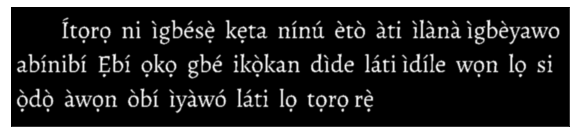

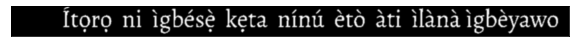

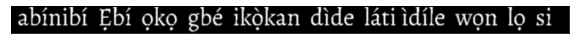

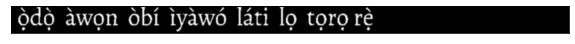

============================Curation complete======================================

 =========================== Correcting line segmentation============================ 


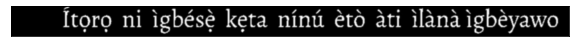

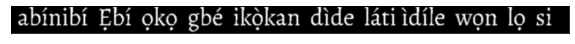

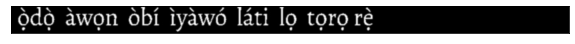


 Using Histogram Projection Method for word segmentation


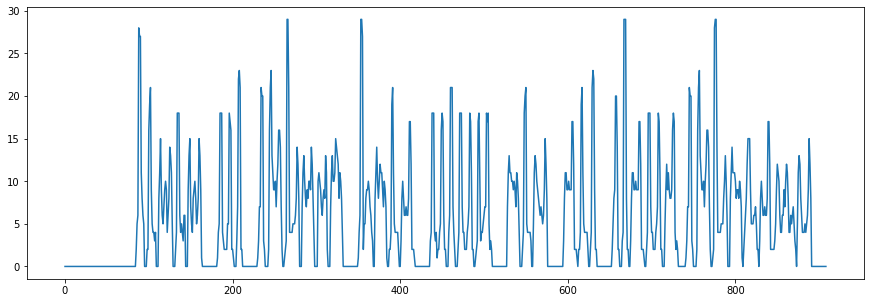


================================= WORD SEGMENTATION COMPLETE FOR LINE 0 COMPLETED ===========================================


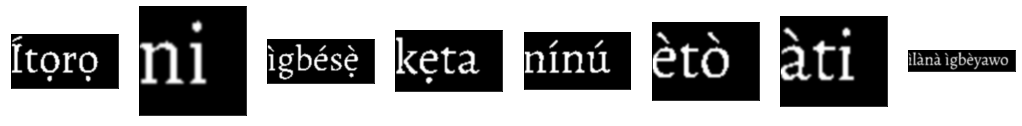


 ==========================LETTER BY LETTER SEGMENTATION=====================================


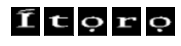


 ==========================LETTER BY LETTER SEGMENTATION=====================================


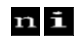


 ==========================LETTER BY LETTER SEGMENTATION=====================================


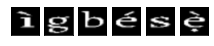


 ==========================LETTER BY LETTER SEGMENTATION=====================================


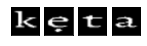


 ==========================LETTER BY LETTER SEGMENTATION=====================================


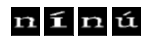


 ==========================LETTER BY LETTER SEGMENTATION=====================================


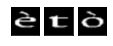


 ==========================LETTER BY LETTER SEGMENTATION=====================================


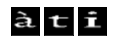


 ==========================LETTER BY LETTER SEGMENTATION=====================================


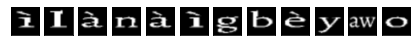


 Using Histogram Projection Method for word segmentation


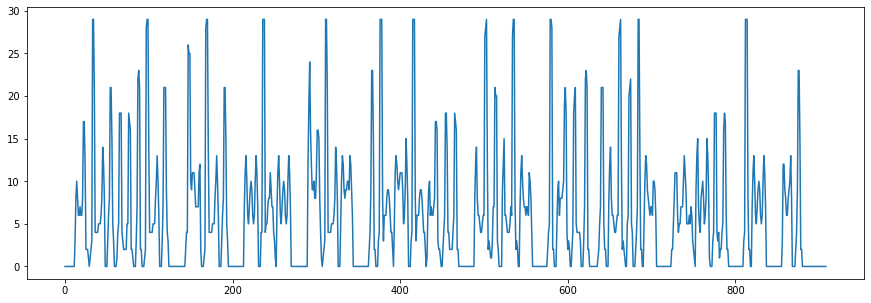


================================= WORD SEGMENTATION COMPLETE FOR LINE 1 COMPLETED ===========================================


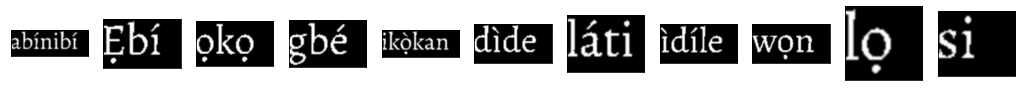


 ==========================LETTER BY LETTER SEGMENTATION=====================================


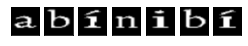


 ==========================LETTER BY LETTER SEGMENTATION=====================================


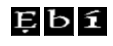


 ==========================LETTER BY LETTER SEGMENTATION=====================================


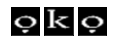


 ==========================LETTER BY LETTER SEGMENTATION=====================================


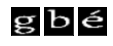


 ==========================LETTER BY LETTER SEGMENTATION=====================================


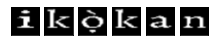


 ==========================LETTER BY LETTER SEGMENTATION=====================================


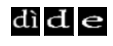


 ==========================LETTER BY LETTER SEGMENTATION=====================================


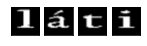


 ==========================LETTER BY LETTER SEGMENTATION=====================================


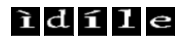


 ==========================LETTER BY LETTER SEGMENTATION=====================================


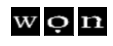


 ==========================LETTER BY LETTER SEGMENTATION=====================================


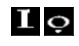


 ==========================LETTER BY LETTER SEGMENTATION=====================================


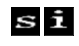


 Using Histogram Projection Method for word segmentation


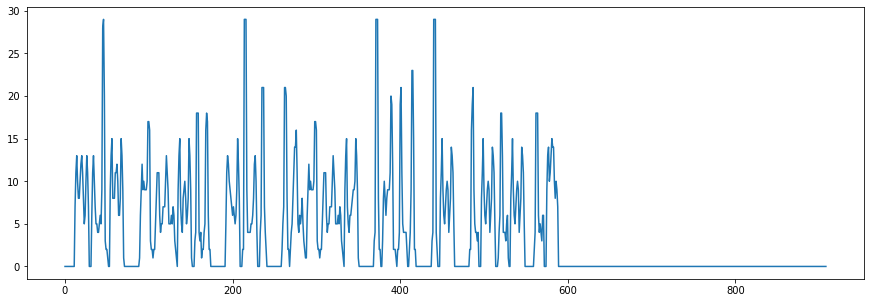


================================= WORD SEGMENTATION COMPLETE FOR LINE 2 COMPLETED ===========================================


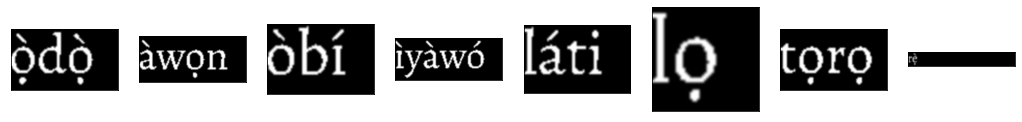


 ==========================LETTER BY LETTER SEGMENTATION=====================================


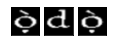


 ==========================LETTER BY LETTER SEGMENTATION=====================================


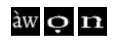


 ==========================LETTER BY LETTER SEGMENTATION=====================================


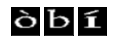


 ==========================LETTER BY LETTER SEGMENTATION=====================================


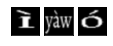


 ==========================LETTER BY LETTER SEGMENTATION=====================================


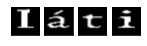


 ==========================LETTER BY LETTER SEGMENTATION=====================================


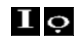


 ==========================LETTER BY LETTER SEGMENTATION=====================================


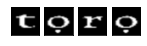


 ==========================LETTER BY LETTER SEGMENTATION=====================================


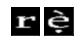

'ÍtỌrọ  ni  ìgbésẹ̀   kẹta  nínú  ètÒ  àti  ìIànàìgbèymO  abínibí  Ẹbí  ỌkỌ  gbé  ikỌ̀ kan  Ọ̀ de  laÉi  ìdíIe  WỌn  IỌ  Si  ọ̀ dỌ̀   wỌn  Òbí  ìẸ̀ Ó  Iati  IỌ  tỌrỌ  Fẹ̀   '

In [28]:
compute(path)

#### **Note:    We can see the the model makes little mistakes.. Most mistakes are differentiating capital letters from small letters. Since deep learning models require more data, by getting more data, we'll be able to produce a more accurate model. Also, by re-training the model along with the samples images that was used for testing.**
**Also, sometimes, Segmentation doesn't work well with all images due to the lightning of the image, to solve this, the threshold for binarizing can be easily adjusted.**

Although, if we take a look at the images causing the error, we would notice that most of them can't be correctly classified based on human vision **like in the case of "l" in the image predicted as "I"(This is also due to the font used in the image)** . So this is a good sign that are model is still much accurate based on the data it was trained on... To resolve this issue, language models can be applied to the result of this model to predict the correct spelling of words in sentences.

Thank you...